# Imports

In [1]:
# Suprress warnings
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Standard imports
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import numpy as np

    # Drake imports
    from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
    import pydrake
    from pydrake.all import LogOutput, DirectCollocation, DirectTranscription, MathematicalProgram, InputPortSelection

# Imports of other project files
from log_wrapper import LogWrapper
import constants
import finger
import pedestal
from paper import Paper

from pydrake.all import (MultibodyPlant, Parser, DiagramBuilder, Simulator,
                         PlanarSceneGraphVisualizer, SceneGraph, TrajectorySource,
                         SnoptSolver, MultibodyPositionToGeometryPose, PiecewisePolynomial,
                         MathematicalProgram, JacobianWrtVariable, eq, RollPitchYaw, AutoDiffXd, BodyIndex)

# Other imports
import importlib

import scipy.interpolate

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
# Matplotlib configuring
plt.style.use(['science', 'no-latex'])
font = {'size'   : 14}
matplotlib.rc('font', **font)

In [3]:
# Meshcat init
proc, zmq_url, web_url = start_zmq_server_as_subprocess()

# Simulation setup
## Pre-finalize steps

In [4]:
builder = pydrake.systems.framework.DiagramBuilder()

# Add all elements
plant, scene_graph = pydrake.multibody.plant.AddMultibodyPlantSceneGraph(builder, time_step=constants.DT)
v_stiction=1e-3
plant.set_stiction_tolerance(v_stiction)
pedestal_instance = pedestal.AddPedestal(plant)

# These joint angles start the paper approximately the right spot, no matter how many links are used
num_links = 2
# def_joint_angles = list(np.zeros(num_links))
# def_joint_angles[0] = np.pi/100
# def_joint_angles[1] = np.pi/100
# def_joint_angles[int(num_links*0.65)-2] = -np.pi/10
# def_joint_angles[int(num_links*0.65)-1] = -np.pi/10
# def_joint_angles[int(num_links*0.65)] = -np.pi/10
# def_joint_angles[int(num_links*0.65)+1] = -np.pi/10
# # def_joint_angles[int(num_links*0.65)+2] = -np.pi/10
def_joint_angles = 0#np.pi/3

paper = Paper(plant, scene_graph, num_links, "NATURAL", default_joint_angle=def_joint_angles,
              stiffness=2.5e-2,
              damping=7.12547340446979e-06)
paper.weld_paper_edge(pedestal.PEDESTAL_WIDTH, pedestal.PEDESTAL_HEIGHT)

finger_instance, finger_body = finger.AddFinger(plant, constants.INIT_Y, constants.INIT_Z)

# Set up logger (needs to happen after all bodies are added)
log_wrapper = LogWrapper(plant.num_bodies(), int(finger_body.index()), paper.get_free_edge_idx())
builder.AddSystem(log_wrapper)

Calculate link inertia to use in damping calculations:

In [5]:
paper.plant.get_body(BodyIndex(paper.get_free_edge_idx())).default_rotational_inertia().CalcPrincipalMomentsOfInertia()[0]

0.00016346741666666662

## Controller selection

In [6]:
## CHOOSE CONTROL SYSTEM HERE BY UNCOMMENTING
# # PD control: hits too low
# finger_ctrlr = finger.PDFinger(
#     plant,
#     int(finger_instance),
#     [
#         [constants.INIT_Y, constants.INIT_Z],
#         [constants.INIT_Y*1.1, constants.INIT_Z],
#         [constants.INIT_Y*1.1, pedestal.PEDESTAL_HEIGHT+constants.FINGER_RADIUS/2+0.05],
#         [0, pedestal.PEDESTAL_HEIGHT+constants.FINGER_RADIUS/2+0.05],
#         [0, pedestal.PEDESTAL_HEIGHT+constants.FINGER_RADIUS/2],
#     ],
#     tspan_per_segment=1,
#     ky=10,
#     kz=10
# )

# PD control: hits too high
# finger_ctrlr = finger.PDFinger(
#     plant,
#     int(finger_instance),
#     [
#         [constants.INIT_Y, constants.INIT_Z],
#         [constants.INIT_Y*1.1, constants.INIT_Z],
#         [constants.INIT_Y*1.1, pedestal.PEDESTAL_HEIGHT+constants.FINGER_RADIUS/2+0.08],
#         [0, pedestal.PEDESTAL_HEIGHT+constants.FINGER_RADIUS/2+0.08],
#         [0, pedestal.PEDESTAL_HEIGHT+constants.FINGER_RADIUS/2],
#     ],
#     tspan_per_segment=1,
#     ky=10,
#     kz=10
# )


# Edge feedback
finger_ctrlr = finger.EdgeController(
    plant,
    paper,
    int(finger_instance),
    F_Nd=2,
    debug=True,
)

# # Optimization controller
# finger_ctrlr = finger.OptimizationController(
#     plant,
#     paper,
#     int(finger_instance),
#     paper.get_free_edge_instance()
# )

# Blank controller
# finger_ctrlr = finger.BlankController(
#     plant,
#     int(finger_instance)
# )

## Post-finalize steps

In [7]:
plant.Finalize()

## Post finalize steps
# Conect finger controller
builder.AddSystem(finger_ctrlr)
builder.Connect(finger_ctrlr.get_output_port(), plant.get_actuation_input_port(finger_instance))
builder.Connect(plant.get_body_poses_output_port(), finger_ctrlr.get_input_port(0))
builder.Connect(plant.get_body_spatial_velocities_output_port(), finger_ctrlr.get_input_port(1))

# Add logger
builder.Connect(plant.get_body_poses_output_port(), log_wrapper.get_input_port(0))
builder.Connect(plant.get_body_spatial_velocities_output_port(), log_wrapper.get_input_port(1))
builder.Connect(plant.get_body_spatial_accelerations_output_port(), log_wrapper.get_input_port(2)) 
builder.Connect(plant.get_contact_results_output_port(), log_wrapper.get_input_port(3)) 

# Visualization and logging
logger = LogOutput(log_wrapper.get_output_port(), builder)
vis = pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(builder, scene_graph)
vis.set_planar_viewpoint(camera_position=[1, 0, 0], xmin=-0.3, xmax=0.3, ymin=-0.3, ymax=0.3)

# Build diagram and do actions requiring 
diagram = builder.Build()
diagram_context = diagram.CreateDefaultContext()

[2021-02-03 10:46:18.502] [console] [warning] Currently MultibodyPlant does not handle joint limits for continuous models. However some joints do specify limits. Consider setting a non-zero time step in the MultibodyPlant constructor; this will put MultibodyPlant in discrete-time mode, which does support joint limits.
[2021-02-03 10:46:18.506] [console] [warning] Joints that specify limits are: `finger_y`, `finger_z`.
[2021-02-03 10:46:18.517] [console] [warning] Currently MultibodyPlant does not handle joint limits for continuous models. However some joints do specify limits. Consider setting a non-zero time step in the MultibodyPlant constructor; this will put MultibodyPlant in discrete-time mode, which does support joint limits.
[2021-02-03 10:46:18.518] [console] [warning] Joints that specify limits are: `finger_y`, `finger_z`.


Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.


In [8]:
if type(finger_ctrlr) is finger.OptimizationController:
    finger_ctrlr.optimize(plant.GetPositions(diagram_context))

# Run simulation

In [9]:
# Finalize simulation and visualization
simulator = pydrake.systems.analysis.Simulator(diagram, diagram_context)
simulator.Initialize()
vis.start_recording()
try:
    simulator.AdvanceTo(constants.TSPAN)
except RuntimeError as e:
    print(e)

# This way, we can use the actual time the simulation ran for
effective_tspan = max(logger.sample_times())

vis.stop_recording()
vis.publish_recording()

# Plots used in orginal paper

In [10]:
# Plot manipulator position vs. trajectory
# PROGRAMMING: Use body index for finger instead of model instance
if type(finger_ctrlr) is finger.PDFinger:
    plt.figure(figsize=(2*3,2*2))
    plt.plot(logger.data()[log_wrapper.entries_per_body*int(finger_instance)+1],
             logger.data()[log_wrapper.entries_per_body*int(finger_instance)+2],
             label='Manipulator position')
    plt.plot(finger_ctrlr.ys, finger_ctrlr.zs, label='Trajectory')
    plt.xlabel("$y$ position")
    plt.ylabel("$z$ position")
    plt.legend()
    plt.show()

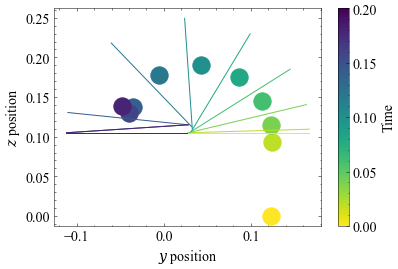

In [11]:
# Generate plots for paper
nb = plant.num_bodies()
y_traces = []
z_traces = []
theta_traces = []
for b in paper.link_idxs:
    y_traces.append(logger.data()[log_wrapper.entries_per_body*b+1])
    z_traces.append(logger.data()[log_wrapper.entries_per_body*b+2])
    theta_traces.append(logger.data()[log_wrapper.entries_per_body*b+3])
y_traces = np.array(y_traces)
z_traces = np.array(z_traces)
theta_traces = np.array(theta_traces)

times = np.arange(0,effective_tspan, effective_tspan/10)
cmap = cm.get_cmap("viridis_r")
plt.figure(figsize=(2*3,2*2))
if type(finger_ctrlr) is finger.PDFinger:
    plt.plot(finger_ctrlr.ys, finger_ctrlr.zs, '--k', zorder=-1)
for t in times:
    c = cmap(t/effective_tspan)
    idx = np.argmax(logger.sample_times() >= t)
    
    # Plot paper
    # PROGRAMMING: Account for paper thickness in plots
    for y, z, theta in zip(y_traces[:,idx], z_traces[:,idx], theta_traces[:,idx]):
        y0 = y - np.cos(theta)*paper.link_width/2
        z0 = z - np.sin(theta)*paper.link_width/2
        y1 = y + np.cos(theta)*paper.link_width/2
        z1 = z + np.sin(theta)*paper.link_width/2
        plt.plot([y0, y1], [z0, z1], color=c)
        
    
    # Plot manipulator
    plt.scatter(logger.data()[log_wrapper.entries_per_body*int(finger_instance)+1,idx], 
                logger.data()[log_wrapper.entries_per_body*int(finger_instance)+2,idx],
                color=c, s=300, zorder=1)

xlim = plt.xlim()
ylim = plt.ylim()
plt.scatter([xlim[0]-50, xlim[0]-50], [ylim[0]-50, ylim[0]-50], c=[0, effective_tspan], cmap=cmap)
plt.xlim(xlim)
plt.ylim(ylim)
cb = plt.colorbar()
cb.set_label("Time")
plt.xlabel("$y$ position")
plt.ylabel("$z$ position")
plt.show()

This is a sanity check to see how much force we're neglecting by ignoring drag. The colored lines are the drag forces at each link, and the dashed black line is the force due to gravity for scale.

Note that the formula for drag force is $\rho v^2 C_d A_{paper}$.

$C_d$ comes from [this site](https://www.engineersedge.com/fluid_flow/rectangular_flat_plate_drag_14036.htm), which says it depends on $L/d$. For 20 links, $L/d\approx15$. Rounding this down to 10, we get $C_d=1.22$.

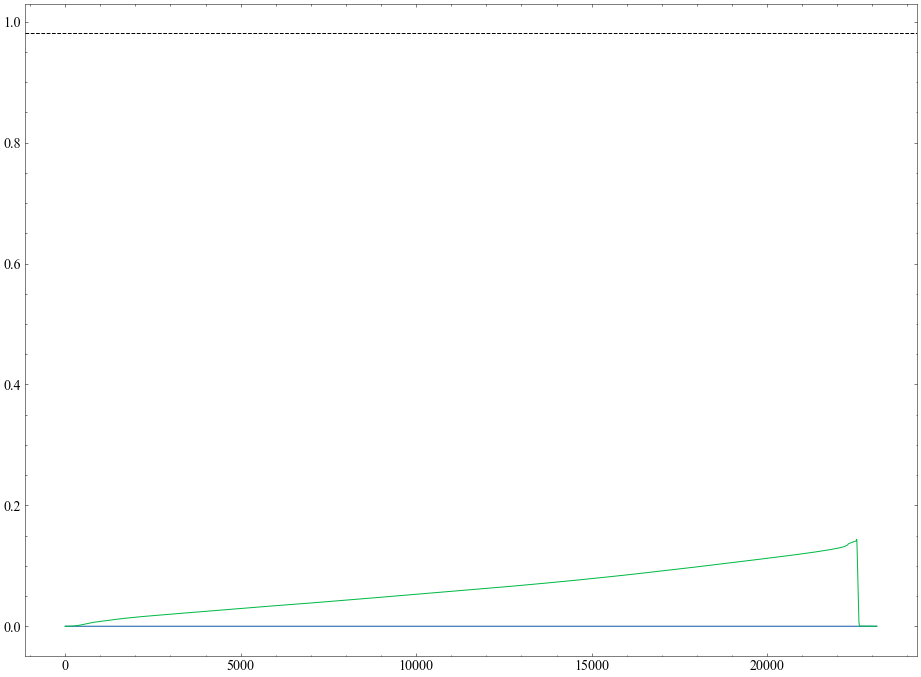

In [12]:
# Plot drag forces
plt.figure(figsize=(16, 12))
nb = plant.num_bodies
vel_traces = []
for b in paper.link_idxs:
    rho = 1.225
    C_d = paper.link_width*paper.depth
    vel_sqred = logger.data()[log_wrapper.entries_per_body*b+7]**2+logger.data()[log_wrapper.entries_per_body*b+8]**2
    f = 0.5*rho*C_d*vel_sqred
    plt.plot(f)

plt.axhline(paper.link_mass*9.81, color='black', linestyle='--')
plt.show()

# Debug plots

In [13]:
# Get debug dict
debug = finger_ctrlr.debug
times = np.arange(len(debug['d_Ns']))*effective_tspan/len(debug['d_Ns'])
dt = effective_tspan/len(debug['d_Ns'])

## Unit vectors

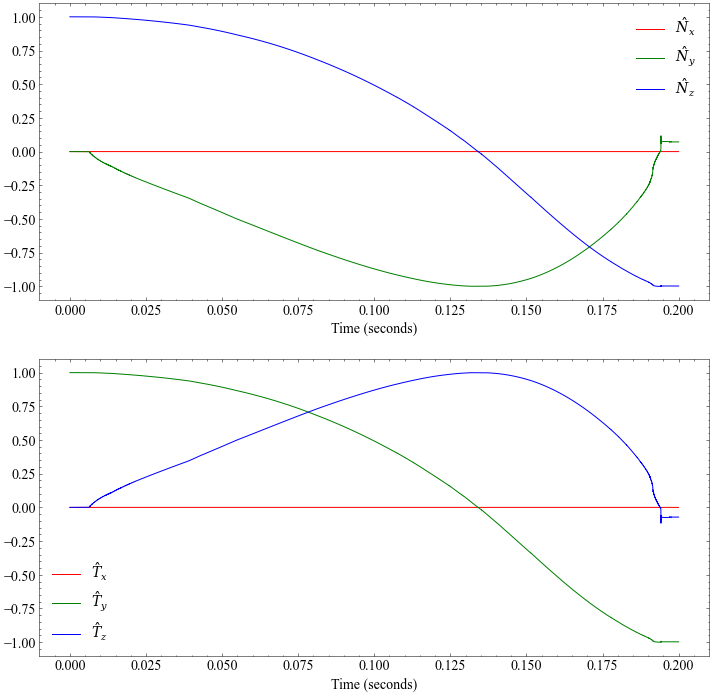

In [14]:
N_Hats = np.array(debug['N_hats'])
T_Hats = np.array(debug['T_hats'])
plt.figure(figsize=(12, 12))
plt.subplot(211)
plt.plot(times, N_Hats[:,0,:], label='$\hat N_x$', color='red')
plt.plot(times, N_Hats[:,1,:], label='$\hat N_y$', color='green')
plt.plot(times, N_Hats[:,2,:], label='$\hat N_z$', color='blue')
plt.xlabel("Time (seconds)")
plt.legend()
plt.subplot(212)
plt.plot(times, T_Hats[:,0,:], label='$\hat T_x$', color='red')
plt.plot(times, T_Hats[:,1,:], label='$\hat T_y$', color='green')
plt.plot(times, T_Hats[:,2,:], label='$\hat T_z$', color='blue')
plt.xlabel("Time (seconds)")
plt.legend()
plt.show()

### Projection matrices
Gives a $k\times 3 \times 3$ array that can be used with `matmul` and vectors stacked in a $k\times 3 \times 1$ shape.

In [15]:
# Transpose with [0, 2, 1] swaps only the last two rows
N_hat_proj_mats = np.matmul(N_Hats, np.transpose(N_Hats, [0, 2, 1]))
T_hat_proj_mats = np.matmul(T_Hats, np.transpose(T_Hats, [0, 2, 1]))

## $d_T$ and $d_N$

In [16]:
separation_speed = logger.data()[-log_wrapper.contact_entries+3,:]
slip_speed = logger.data()[-log_wrapper.contact_entries+4,:]

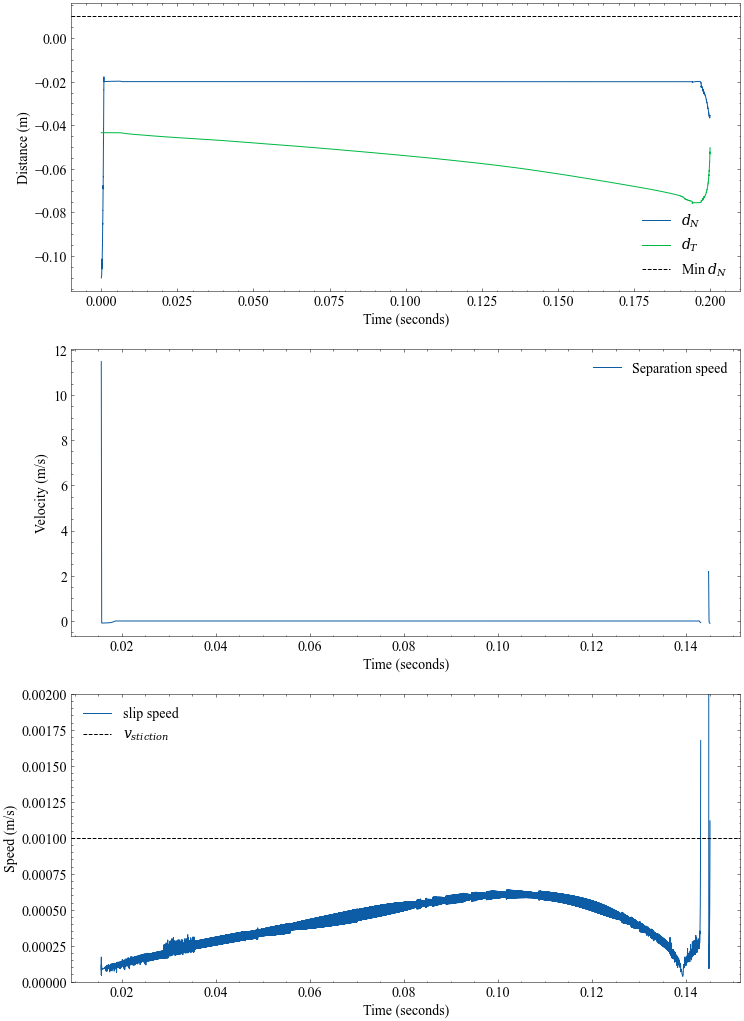

In [17]:
lw=1

plt.figure(figsize=(12, 18))
plt.subplot(311)
plt.plot(times, np.array(debug['d_Ns']), label='$d_N$', linewidth=lw)
plt.plot(times, debug['d_Ts'], label='$d_T$', linewidth=lw)
plt.axhline(constants.FINGER_RADIUS, label='Min $d_N$', linestyle='--', color='k', linewidth=lw)
plt.legend()
plt.xlabel("Time (seconds)")
plt.ylabel("Distance (m)")

plt.subplot(312)
plt.plot(logger.sample_times(), separation_speed, label="Separation speed", linewidth=lw)
plt.legend()
plt.xlabel("Time (seconds)")
plt.ylabel("Velocity (m/s)")

plt.subplot(313)
plt.plot(logger.sample_times(), slip_speed, label="slip speed")
plt.axhline(v_stiction, linestyle="--", color="k", label="$v_{stiction}$")
plt.legend()
plt.xlabel("Time (seconds)")
plt.ylabel("Speed (m/s)")
plt.ylim(0, 2*v_stiction)
plt.show()

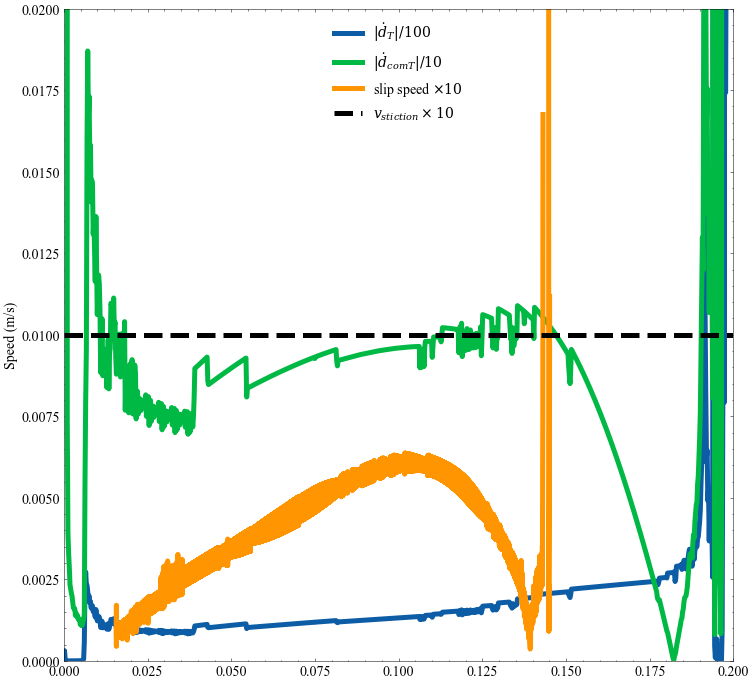

In [18]:
plt.figure(figsize=(12, 12))
step = 100

lw=5

plt.plot(times[:-step:step], 
         np.abs(np.diff(debug['d_Ts'][::step])/np.diff(times[::step])/100), 
         label='$\left|\\dot d_T\\right|/100$', linewidth=lw)
plt.plot(times[:-step:step], 
         np.abs(np.diff(debug['d_coms'][::step])/np.diff(times[::step])/10), 
         label='$\left|\\dot d_{comT}\\right|/10$', linewidth=lw)


plt.plot(logger.sample_times(), slip_speed*10, label="slip speed $\\times 10$", linewidth=lw)

plt.axhline(v_stiction*10, color='k', label="$v_{stiction}\\times 10$", linestyle='--', linewidth=lw)
plt.legend()
plt.ylim(0, 0.02)
plt.xlim(logger.sample_times()[0], logger.sample_times()[-1])
plt.ylabel("Speed (m/s)")

plt.show()

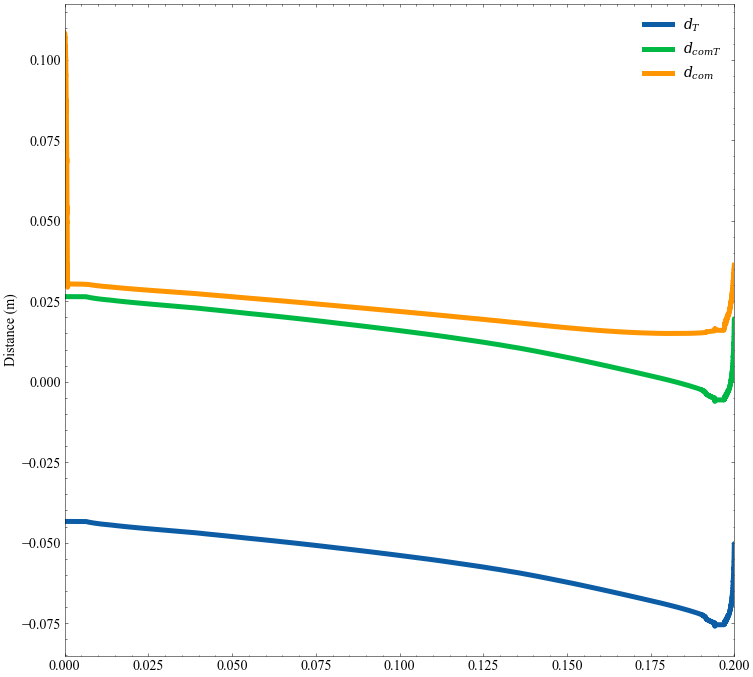

In [19]:
plt.figure(figsize=(12, 12))
lw = 5
plt.plot(times, debug['d_Ts'], label='$d_T$', linewidth=lw)
plt.plot(times, debug['d_com_Ts'], label='$d_{comT}$', linewidth=lw)
plt.plot(times, debug['d_coms'], label='$d_{com}$', linewidth=lw)

plt.legend()
plt.ylabel("Distance (m)")
plt.xlim(logger.sample_times()[0], logger.sample_times()[-1])

plt.show()

## Positions
### Link state

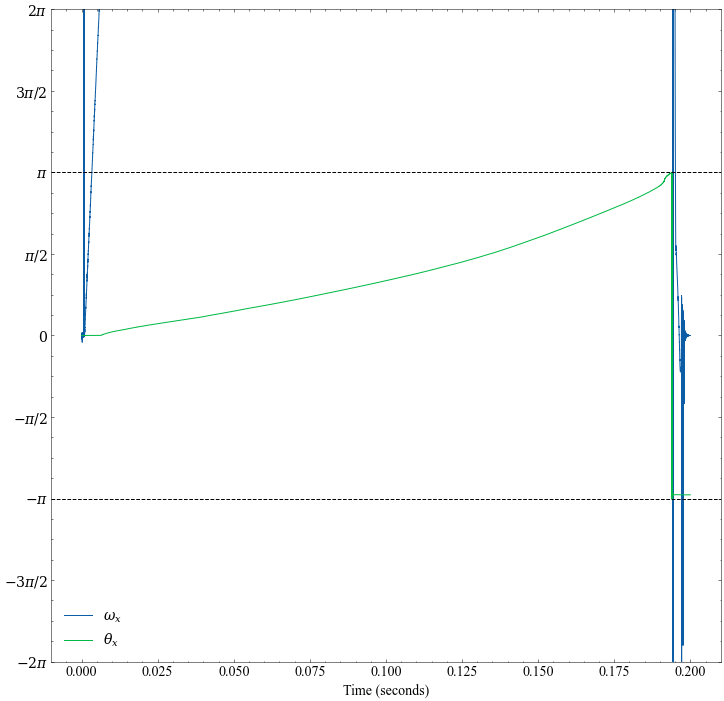

In [20]:
plt.figure(figsize=(12, 12))
plt.plot(times, debug['omega_xs'], label='$\omega_x$')
plt.plot(times, np.array(debug['theta_xs']), label='$\\theta_x$')
plt.legend()
plt.ylim(-2*np.pi, 2*np.pi)
plt.yticks(np.arange(-2, 2.5, 0.5)*np.pi, [
    '$-2\pi$',
    '$-3\pi/2$',
    '$-\pi$',
    '$-\pi/2$',
    '$0$',
    '$\pi/2$',
    '$\pi$',
    '$3\pi/2$',
    '$2\pi$',
])
plt.xlabel("Time (seconds)")
plt.axhline(np.pi, linestyle='--', color='k')
plt.axhline(-np.pi, linestyle='--', color='k')
plt.show()

#### Rotation matrices

In [21]:
thetas = np.array(debug['theta_xs'])

In [22]:
# Rotating theta about the x axis
Rs = np.zeros((thetas.size, 3, 3))
Rs[:, 1, 1] = np.cos(thetas)
Rs[:, 1, 2] = -np.sin(thetas)
Rs[:, 2, 1] = np.cos(thetas)
Rs[:, 2, 2] = np.sin(thetas)
R_invs = np.transpose(Rs, [0, 2, 1])

### Manipulator state

In [23]:
finger_idx = int(finger_body.index())

In [24]:
man_point = logger.data()[log_wrapper.entries_per_body*finger_idx:log_wrapper.entries_per_body*finger_idx+3]

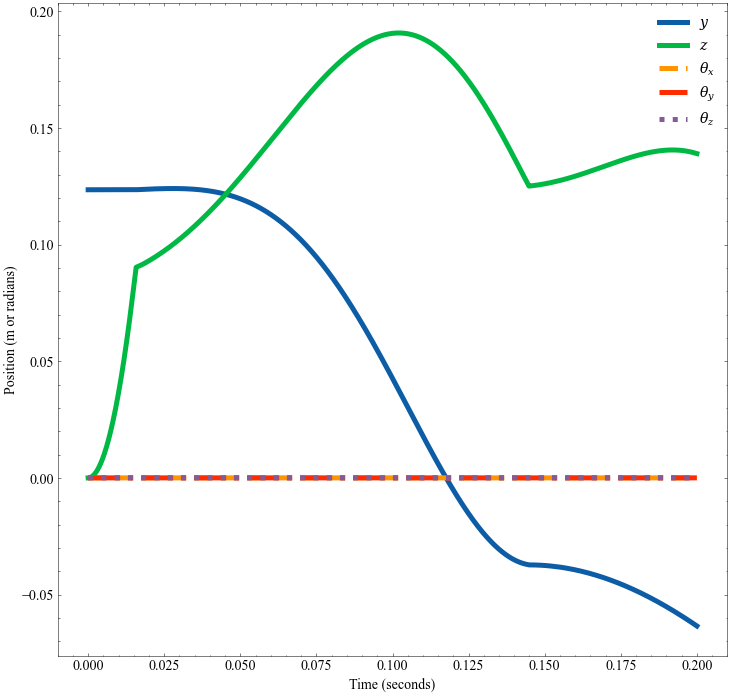

In [25]:
plt.figure(figsize=(12, 12))
lw=5
# plt.plot(logger.sample_times(), logger.data()[
#     log_wrapper.entries_per_body*finger_idx], label="$x$", linewidth=lw, linestyle='--')
plt.plot(logger.sample_times(), logger.data()[
    log_wrapper.entries_per_body*finger_idx+1], label="$y$", linewidth=lw)
plt.plot(logger.sample_times(), logger.data()[
    log_wrapper.entries_per_body*finger_idx+2], label="$z$", linewidth=lw)
plt.plot(logger.sample_times(), logger.data()[
    log_wrapper.entries_per_body*finger_idx+3], label="$\\theta_x$", linewidth=lw, linestyle='--')
plt.plot(logger.sample_times(), logger.data()[
    log_wrapper.entries_per_body*finger_idx+4], label="$\\theta_y$", linewidth=lw, linestyle='dashdot')
plt.plot(logger.sample_times(), logger.data()[
    log_wrapper.entries_per_body*finger_idx+5], label="$\\theta_z$", linewidth=lw, linestyle=':')
plt.legend()
plt.xlabel("Time (seconds)")
plt.ylabel("Position (m or radians)")
plt.show()

### Contact point
 - [ ] PROGRAMMING: Add arrow heads to contact point plots

In [26]:
contact_point = logger.data()[-log_wrapper.contact_entries +5:,:]

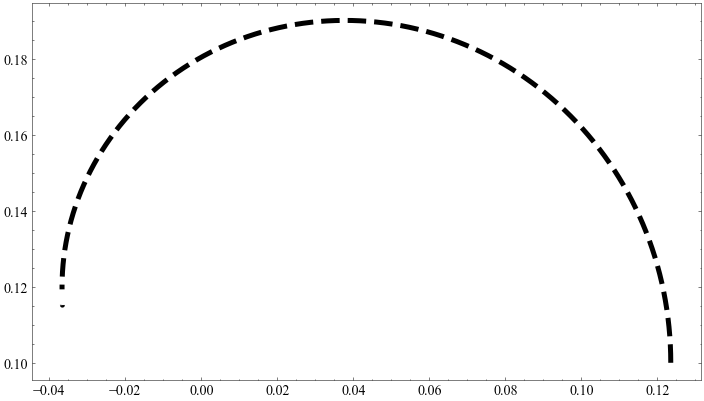

In [27]:
plt.figure(figsize=(12,12))

plt.plot(contact_point[1,:], contact_point[2,:], color='k', linestyle='--', linewidth='5')
plt.gca().set_aspect('equal', 'box')
plt.show()

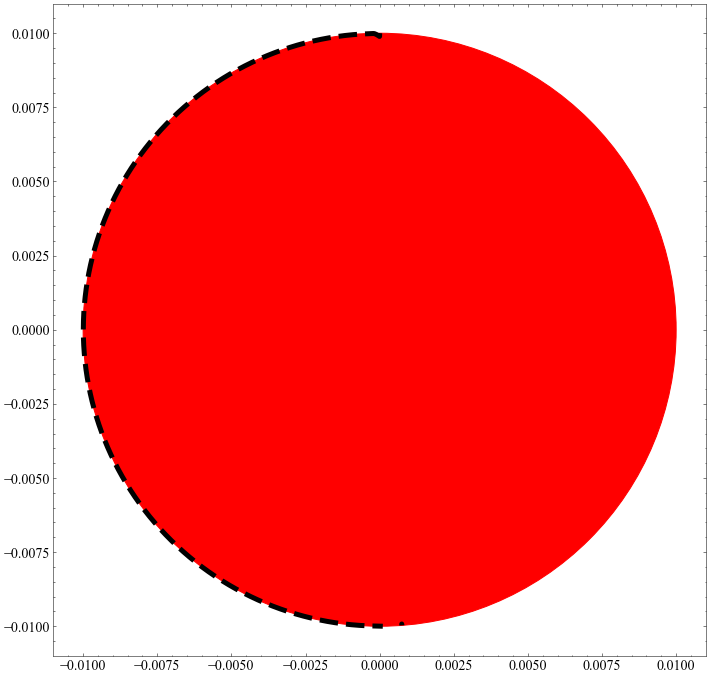

In [28]:
plt.figure(figsize=(12,12))
plt.gca().add_patch(plt.Circle((0, 0), constants.FINGER_RADIUS, color='r'))
plt.plot(contact_point[1,:]-man_point[1,:], contact_point[2,:]-man_point[2,:], color='k', linestyle='--', linewidth='5')
plt.gca().set_aspect('equal', 'box')
plt.show()

#### Contact point vs. speeds

In [74]:
v_contact_point_no_interp = (np.diff(contact_point)/logger.sample_times()[:-1]).T
v_contact_point_no_interp

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       ...,
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])

In [83]:
v_contact_point = scipy.interpolate.interp1d(
    logger.sample_times()[:-1], v_contact_point_no_interp, axis=0, fill_value="extrapolate")(times)

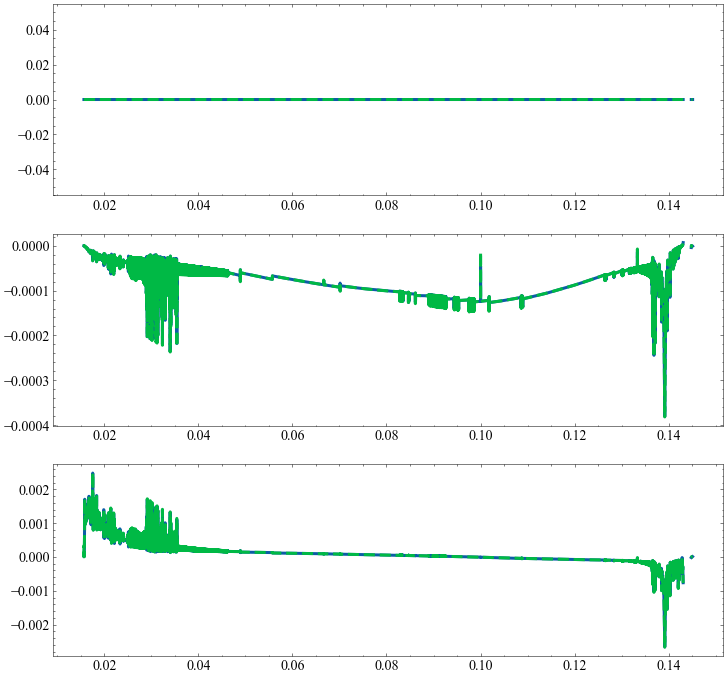

In [92]:
# Check interpolation
lw=3
plt.figure(figsize=(12,12))

plt.subplot(311)
plt.plot(times, v_contact_point[:,0],linewidth=lw)
plt.plot(logger.sample_times()[:-1], v_contact_point_no_interp[:,0],linewidth=lw, linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("$\hat x$ component")

plt.subplot(312)
plt.plot(times, v_contact_point[:,1],linewidth=lw)
plt.plot(logger.sample_times()[:-1], v_contact_point_no_interp[:,1],linewidth=lw, linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("$\hat y$ component")

plt.subplot(313)
plt.plot(times, v_contact_point[:,2],linewidth=lw)
plt.plot(logger.sample_times()[:-1], v_contact_point_no_interp[:,2],linewidth=lw, linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("$\hat z$ component")

plt.show()

They match up, so we've interpolated correctly.

In [94]:
# Convert to matrix in manipulator basis
M_v_contact_point = np.expand_dims(v_contact_point, 2)

In [95]:
# Change to compliance basis
C_v_contact_point = np.matmul(R_invs, M_v_contact_point)

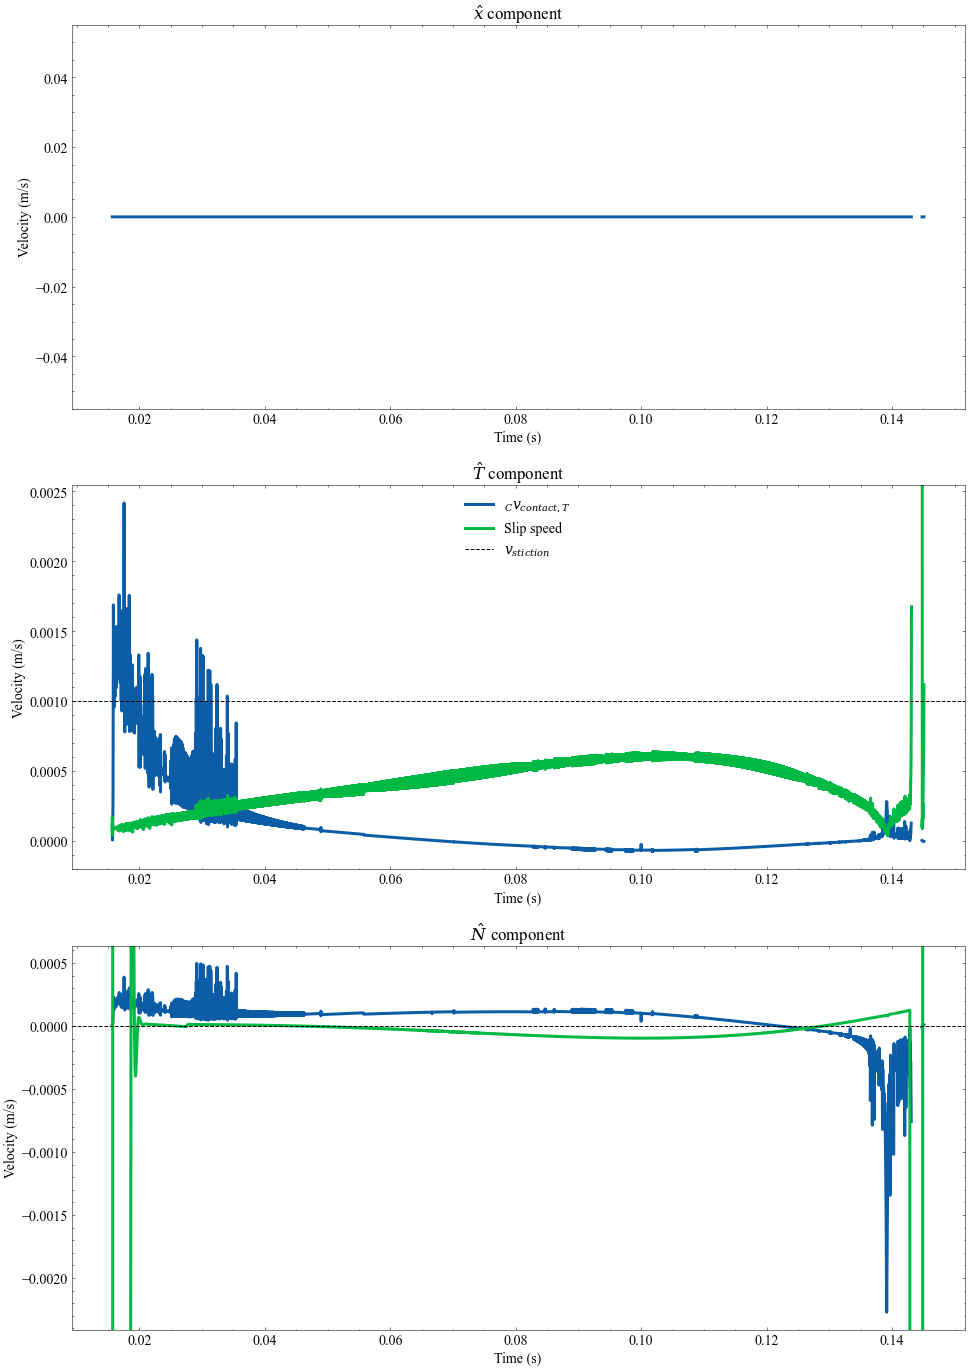

In [108]:
lw=3
plt.figure(figsize=(16,24))

plt.subplot(311)
plt.plot(times, C_v_contact_point[:,0],linewidth=lw, label=r"$_Cv_{contact, x}$")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("$\hat x$ component")

# PROGRAMMING: Is slip speed properly filled with NaNs?
plt.subplot(312)
plt.plot(times, C_v_contact_point[:,1],linewidth=lw, label=r"$_Cv_{contact, T}$")
ylims = plt.ylim()
plt.plot(logger.sample_times(), slip_speed, linewidth=lw, label="Slip speed")
plt.axhline(v_stiction, color='k', linestyle='--', label=r'$v_{stiction}$')
plt.ylim(ylims)
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("$\hat T$ component")
plt.legend()

plt.subplot(313)
plt.plot(times, C_v_contact_point[:,2],linewidth=lw, label=r"$_Cv_{contact, N}$")
ylims = plt.ylim()
plt.plot(logger.sample_times(), separation_speed, linewidth=lw, label="Separation speed")
plt.axhline(0, color='k', linestyle='--')
plt.ylim(ylims)
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("$\hat N$ component")

plt.show()

Hm. I would expect these to link up more closely. Let's double check their defintions in drake documentation:

`slip_speed` ([link](https://drake.mit.edu/doxygen_cxx/classdrake_1_1multibody_1_1_point_pair_contact_info.html#a6d2da20c96fa99be810b28ef0705214c)):
> Returns the slip speed between body A and B at contact point C.

`separation speed` ([link](https://drake.mit.edu/doxygen_cxx/classdrake_1_1multibody_1_1_point_pair_contact_info.html#a61a3bf4aed134902cb0354fa20feedb4])):
> Returns the separation speed between body A and B along the normal direction (see PenetrationAsPointPair::nhat_BA_W) at the contact point.
>
> It is defined positive for bodies moving apart in the normal direction.

Hm. I'm intrigued by `nhat_BA_W`; maybe my $\hat N$ is not what Drake is using. Let's check its definition:

## Forces

In [29]:
# Friction force on manipulor, assuming static friction
total_m_FF = np.array(debug['F_GTs'])+np.array(debug['F_OTs'])-np.array(debug['F_CTs'])
# Total force on the link in the N hat direction 
total_l_FN = np.array(debug['F_Ns'])+np.array(debug['F_GNs'])+np.array(debug['F_ONs'])

### $\hat N$ acceleration
Take the acceleration in the $\hat N$ direction and then multiply by the mass. This is a check that the forces I'm summing in the $\hat N$ direction are actually all the forces on the object.

In [30]:
ll_idx = paper.get_free_edge_idx()
a_vecs_no_interp = logger.data()[log_wrapper.entries_per_body*ll_idx+12:log_wrapper.entries_per_body*ll_idx+15].T
a_vecs_no_interp = np.expand_dims(a_vecs_no_interp, 2)

In [31]:
M_a_vecs = scipy.interpolate.interp1d(logger.sample_times(), a_vecs_no_interp, axis=0)(times)
C_a_vecs = np.matmul(R_invs, M_a_vecs)
a_N = C_a_vecs[:,2]
F_from_acc = paper.link_mass*a_N

### Contact forces

In [32]:
M_F_contact_yz = logger.data()[-log_wrapper.contact_entries+1:-log_wrapper.contact_entries+3,:]

In [33]:
-log_wrapper.contact_entries + log_wrapper._size

108

In [34]:
M_F_contact_yz.shape

(2, 23127)

In [35]:
plant.num_bodies()*log_wrapper.entries_per_body

108

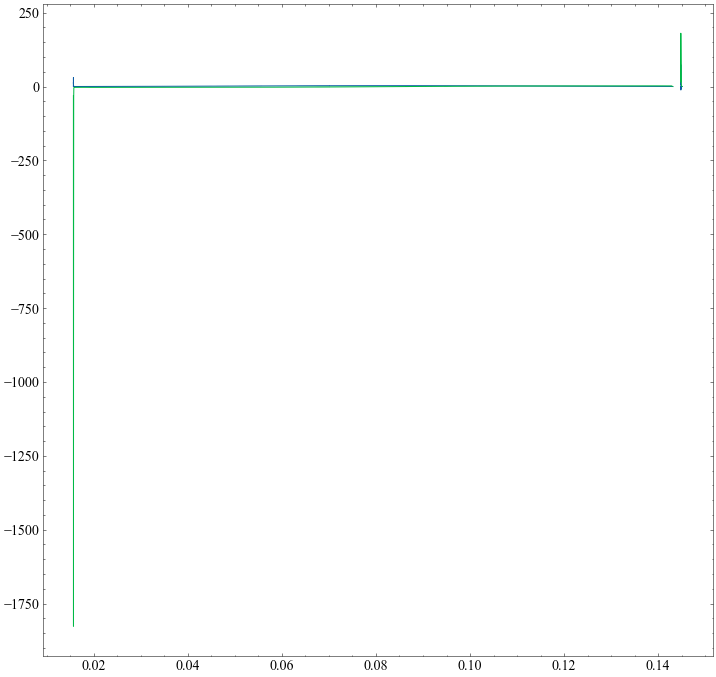

In [36]:
plt.figure(figsize=(12,12))
plt.plot(logger.sample_times(), M_F_contact_yz[0,:])
plt.plot(logger.sample_times(), M_F_contact_yz[1,:])
plt.show()

In [37]:
# Add on empty row of zeros for x
M_F_contact_x = np.zeros((1, M_F_contact_yz.shape[1]))
M_F_contact_no_interp = np.expand_dims(np.vstack((M_F_contact_x, M_F_contact_yz)).T, 2)
M_F_contact = scipy.interpolate.interp1d(logger.sample_times(), M_F_contact_no_interp, axis=0)(times)

In [38]:
# Get T and N hat projections
C_F_contact = np.matmul(R_invs, M_F_contact)
F_contact_T = C_F_contact[:,1]
F_contact_N = C_F_contact[:,2]

### Tangential

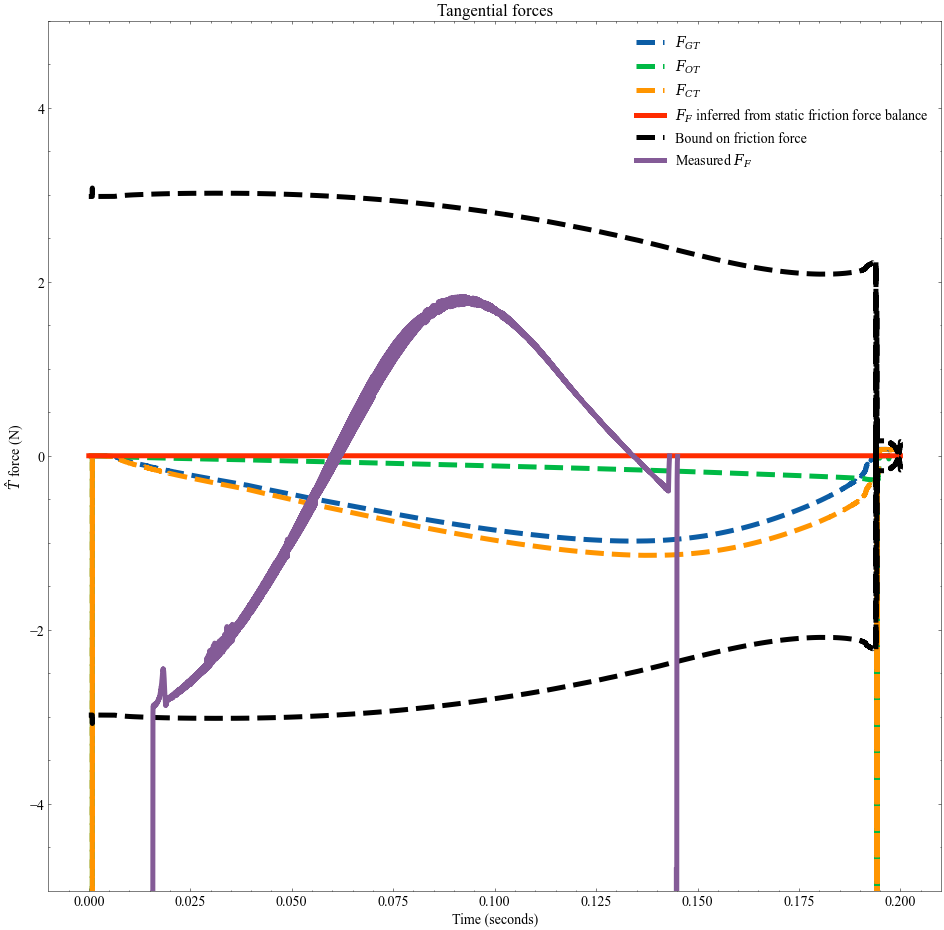

In [39]:
plt.figure(figsize=(16, 16))
lw = 5
plt.title("Tangential forces")
F_GTs = np.array(debug['F_GTs'])
F_OTs = np.array(debug['F_OTs'])
F_CTs = np.array(debug['F_CTs'])
plt.plot(times, debug['F_GTs'], label='$F_{GT}$', linewidth=lw, linestyle='--')
plt.plot(times, debug['F_OTs'], label='$F_{OT}$', linewidth=lw, linestyle='--')
plt.plot(times, debug['F_CTs'], label='$F_{CT}$', linewidth=lw, linestyle='--')
# plt.plot(times, F_GTs + F_OTs, label='$F_{GT}+F_{OT}$', linewidth=lw, linestyle='--')
plt.plot(times, total_m_FF, label='$F_F$ inferred from static friction force balance', linewidth=lw)
plt.plot(times, -2*constants.FRICTION*np.array(debug['F_Ns']), 'k--', label="Bound on friction force", linewidth=lw)
plt.plot(times, 2*constants.FRICTION*np.array(debug['F_Ns']), 'k--', linewidth=lw)
plt.plot(times, F_contact_T, label="Measured $F_F$", linewidth=lw)
# plt.plot(times, np.array(debug['d_Ts'])*100, label='$d_T\\times 100$', linewidth=lw)
# plt.plot(logger.sample_times(), separation_speed, label="Separation speed", linewidth=lw)
plt.legend()
plt.xlabel("Time (seconds)")
plt.ylabel("$\hat T$ force (N)")
plt.ylim(-5, 5)
plt.show()

# PROGRAMMING: Let's get the actual contact forces, and possibly also compare the tangential acceleration, on this plot.

### Normal

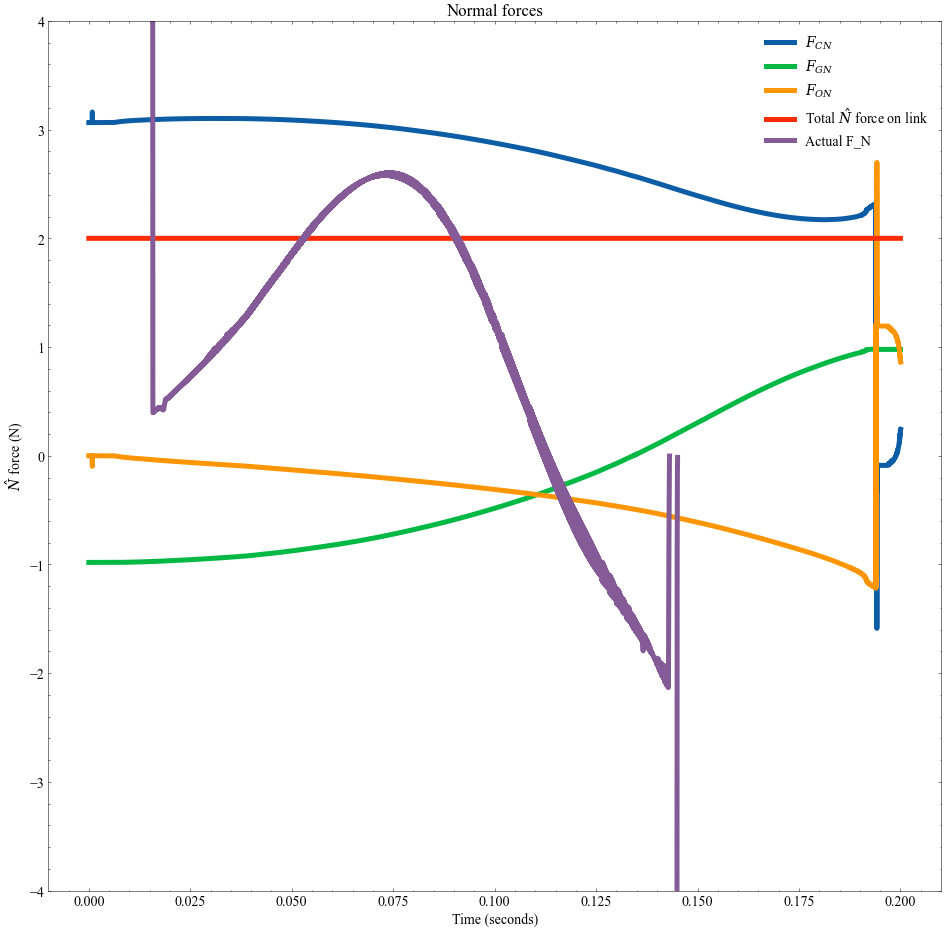

In [40]:
plt.figure(figsize=(16, 16))
lw = 5
plt.title("Normal forces")
plt.plot(times, debug['F_CNs'], label='$F_{CN}$', linewidth=lw)
plt.plot(times, debug['F_GNs'], label='$F_{GN}$', linewidth=lw)
plt.plot(times, debug['F_ONs'], label='$F_{ON}$', linewidth=lw)
plt.plot(times, total_l_FN, label='Total $\hat N$ force on link', linewidth=lw)
# plt.plot(times, F_from_acc, label='Total force, according to acceleration')
plt.plot(times, -F_contact_N, label='Actual F_N', linewidth=lw)
# plt.axhline(finger_ctrlr.F_Nd, color='k', linestyle='--', label='Target force')
plt.ylim(-finger_ctrlr.F_Nd*2, finger_ctrlr.F_Nd*2)
plt.legend()
plt.xlabel("Time (seconds)")
plt.ylabel("$\hat N$ force (N)")
plt.show()

# PROGRAMMING: Why is the force not what my setpoint is?

## Control forces

### Link frame

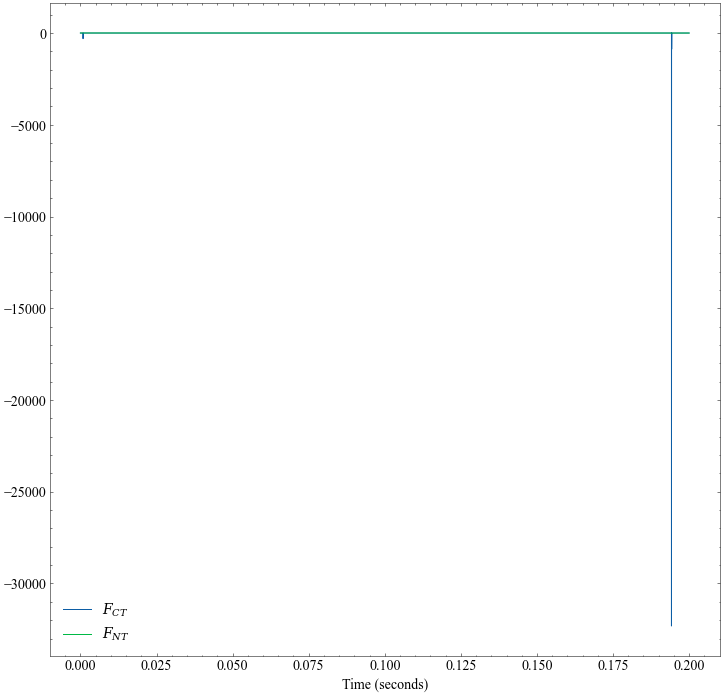

In [41]:
plt.figure(figsize=(12, 12))
plt.plot(times, debug['F_CTs'], label='$F_{CT}$')
plt.plot(times, debug['F_CNs'], label='$F_{NT}$')
plt.legend()
plt.xlabel("Time (seconds)")
plt.show()

### Manipulator frame

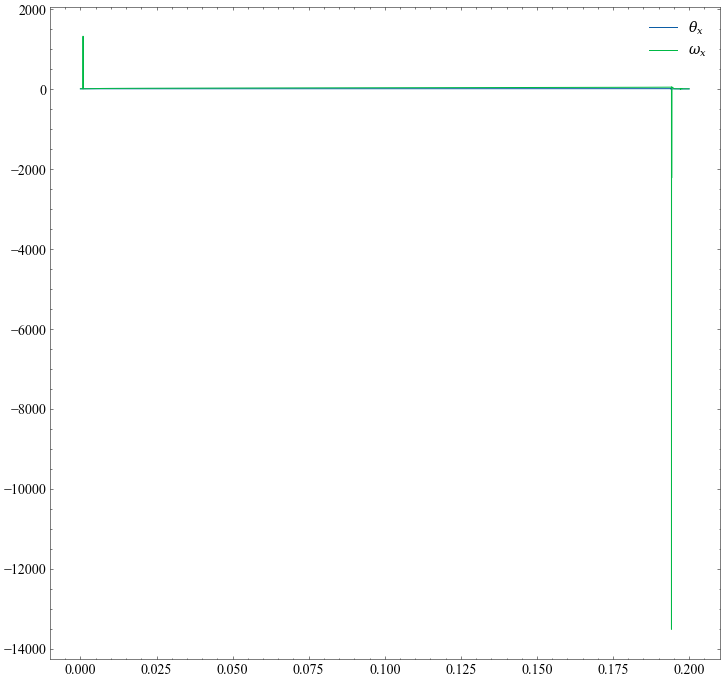

In [42]:
plt.figure(figsize=(12, 12))
plt.plot(times, debug['theta_xs'], label='$\\theta_x$')
plt.plot(times, debug['omega_xs'], label='$\omega_x$')
plt.legend()
plt.show()

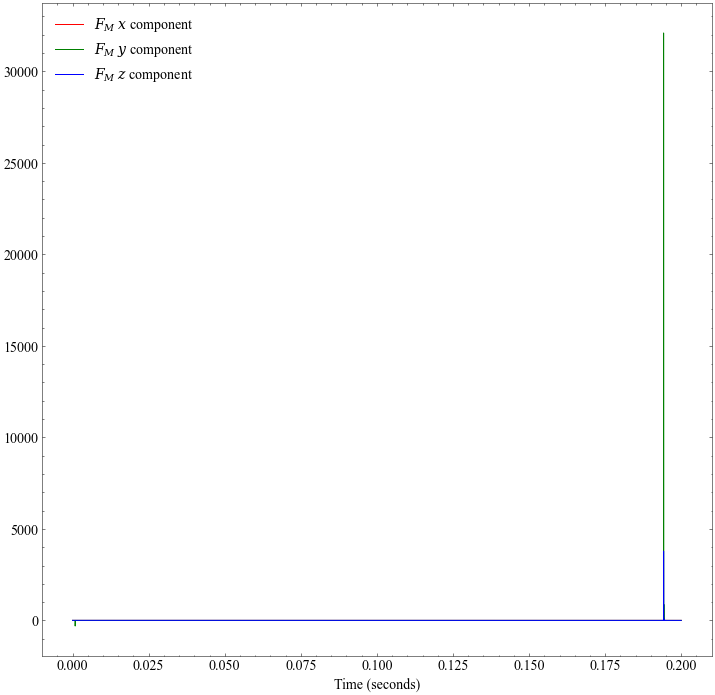

In [43]:
F_Ms = np.array(debug['F_Ms'])
plt.figure(figsize=(12, 12))
plt.plot(times, F_Ms[:,0,:], label='$F_M$ $x$ component', color='red')
plt.plot(times, F_Ms[:,1,:], label='$F_M$ $y$ component', color='green')
plt.plot(times, F_Ms[:,2,:], label='$F_M$ $z$ component', color='blue')
plt.xlabel("Time (seconds)")
plt.legend()
plt.show()